### Fine tuning SAM with OMERO data

TO DO
- clean up tmp files when not neccesary anymore

In [2]:
# Import OMERO Python BlitzGateway
import omero
from omero.gateway import BlitzGateway
import ezomero
# Import Numpy
import numpy as np

# Import Python System Packages
import os
import tempfile
import pandas as pd
import warnings
from tifffile import imwrite

#micro-sam related imports
from micro_sam.sam_annotator import annotator_2d

c:\Users\mwpaul\AppData\Local\miniforge3\envs\micro-sam\lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


### Setup connection with OMERO

In [3]:
conn = BlitzGateway(host='localhost', username='root', passwd='omero', secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


### Get info from the dataset

In [4]:
datatype = "dataset" # "plate", "dataset", "image"
data_id = 652
nucl_channel = 0

#validate that data_id matches datatype
if datatype == "plate":
    plate = conn.getObject("Plate", data_id)
    print('Plate Name: ', plate.getName())
elif datatype == "dataset":
    dataset = conn.getObject("Dataset", data_id)
    print('Dataset Name: ', dataset.getName())
elif datatype == "image":
    image = conn.getObject("Image", data_id)
    print('Image Name: ', image.getName())

Dataset Name:  metadat


### Load images from OMERO and open in napari with micro-sam annotator

In [5]:
new_output_directory = os.path.normcase(tempfile.mkdtemp())
print('Output Directory: ', new_output_directory)

Output Directory:  c:\users\mwpaul\appdata\local\temp\tmpvsoynv8t


In [6]:
import napari
from napari.settings import get_settings
import zipfile
from micro_sam.sam_annotator import image_series_annotator
from micro_sam.util import precompute_image_embeddings

def zip_directory(folder_path, zip_file):
    for folder_name, subfolders, filenames in os.walk(folder_path):
        for filename in filenames:
            # Create complete filepath of file in directory
            file_path = os.path.join(folder_name, filename)
            # Add file to zip
            zip_file.write(file_path)

def interleave_arrays(train_images, validate_images):
    """
    Interleave two arrays of images in the pattern: train[0], validate[0], train[1], validate[1], ...
    If arrays are of unequal length, remaining elements are appended at the end.
    """
    # Create empty list to store interleaved images
    interleaved = []
    sequence = []
    # Get the length of the longer array
    max_len = max(len(train_images), len(validate_images))
    
    # Interleave the arrays
    for i in range(max_len):
        # Add train image if available
        if i < len(train_images):
            interleaved.append(train_images[i])
            sequence.append(0)
        # Add validate image if available
        if i < len(validate_images):
            interleaved.append(validate_images[i])
            sequence.append(1)
    
    return np.array(interleaved), np.array(sequence)

## Running segmentation in batch

In [13]:
import cv2
import numpy as np
import imageio.v3 as imageio
import ezomero

def mask_to_contour(mask):
    """Converts a binary mask to a list of ROI coordinates.

    Args:
        mask (np.ndarray): binary mask

    Returns:
        list: list of ROI coordinates
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def label_to_rois(label_img, z_slice, channel, timepoint):
    """
    Convert a 2D label image to OMERO ROI shapes
    
    Args:
        label_img (np.ndarray): 2D labeled image
        z_slice (int): Z-slice index
        channel (int): Channel index
        timepoint (int): Time point index
    
    Returns:
        list: List of OMERO shape objects
    """
    shapes = []
    unique_labels = np.unique(label_img)
    
    # Skip background (label 0)
    for label in unique_labels[1:]:
        # Create binary mask for this label
        mask = (label_img == label).astype(np.uint8)
        
        # Get contours
        contours = mask_to_contour(mask)
        
        # Convert each contour to polygon ROI
        for contour in contours:
            contour = contour[:, 0, :]  # Reshape to (N, 2)
            # Create polygon without text parameter
            poly = ezomero.rois.Polygon(
                points=contour,  # explicitly name the points parameter
                z=z_slice,
                c=channel,
                t=timepoint
            )
            shapes.append(poly)
    
    return shapes

def upload_rois_and_labels(conn, image, label_file, z_slice, channel, timepoint, model_type):
    """
    Upload both label map and ROIs for a segmented image
    
    Args:
        conn: OMERO connection
        image: OMERO image object
        label_file: Path to the label image file
        z_slice: Z-slice index
        channel: Channel index
        timepoint: Time point index
        model_type: SAM model type used
    
    Returns:
        tuple: (label_id, roi_id)
    """
    # Upload label map as attachment
    label_id = ezomero.post_file_annotation(
        conn,
        str(label_file),
        ns='microsam.labelimage',
        object_type="Image",
        object_id=image.getId(),
        description=f'SAM segmentation ({model_type})'
    )
    
    # Create ROIs from label image
    label_img = imageio.imread(label_file)
    shapes = label_to_rois(label_img, z_slice, channel, timepoint)
    
    if shapes:  # Only create ROI if shapes were found
        roi_id = ezomero.post_roi(
            conn,
            image.getId(),
            shapes,
            name=f'SAM_{model_type}',
            description=f'Segmentation using SAM model {model_type}'
        )
    else:
        roi_id = None
        
    return label_id, roi_id

def process_omero_batch(
    dataset,
    output_folder: str,
    model_type: str = 'vit_l',
    batch_size: int = 3,
    channel: int = 0,
    timepoint: int = 0,
    z_slice: int = 5
):

    """
    Process OMERO dataset in batches for SAM segmentation and upload results back to OMERO
    
    Args:
        dataset: OMERO dataset object
        output_folder: Path to store temporary files
        model_type: SAM model type
        batch_size: Number of images to process at once
        channel: Channel to segment
        timepoint: Timepoint to process
        z_slice: Z-slice to process
    """
    # Setup output directories
    output_path = os.path.join(output_folder, "output")
    embed_path = os.path.join(output_folder, "embed")
    
    # Remove directories if they exist
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    if os.path.exists(embed_path):
        shutil.rmtree(embed_path)
        
    # Create fresh directories
    os.makedirs(output_path)
    os.makedirs(embed_path)
    
    # Get all images from dataset
    images_dataset = list(dataset.listChildren())
    total_batches = (len(images_dataset) + batch_size - 1) // batch_size
    
    df = pd.DataFrame(columns=[
        "image_id", "image_name", "train", "validate", 
        "channel", "timepoint", "sam_model", "embed_id", "label_id", "roi_id"
    ])
    
    # Process images in batches
    for batch_idx in range(total_batches):
    
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(images_dataset))
        batch_images = images_dataset[start_idx:end_idx]
        
        # Load batch images
        images = []
        for image in batch_images:
            pixels = image.getPrimaryPixels()
            img = pixels.getPlane(z_slice, channel, timepoint)
            images.append(img)
        
        # Process batch with SAM
        viewer = napari.Viewer()
        image_series_annotator(
            images, 
            model_type=model_type,
            viewer=viewer,
            embedding_path=os.path.join(output_folder, "embed"),
            output_folder=os.path.join(output_folder, "output")
        )
        napari.run()
        
        # Upload results for batch
        for n, image in enumerate(batch_images):
            local_n = n
            global_n = start_idx + n
            
            # Upload embedding
            embed_file = os.path.join(output_folder, "embed", f"embedding_{local_n:05d}.zarr")
            zip_path = os.path.join(output_folder, "embed", f"embedding_{local_n:05d}.zip")
            
            with zipfile.ZipFile(zip_path, 'w') as zip_file:
                zip_directory(embed_file, zip_file)
            
            embed_id = ezomero.post_file_annotation(
                conn,
                str(zip_path),
                ns='microsam.embeddings',
                object_type="Image",
                object_id=image.getId(),
                description=f'SAM embedding ({model_type})'
            )
            
            # Upload labels and ROIs
            label_file = os.path.join(output_folder, "output", f"seg_{local_n:05d}.tif")
            label_id, roi_id = upload_rois_and_labels(
                conn, 
                image, 
                label_file, 
                z_slice, 
                channel, 
                timepoint, 
                model_type
            )
            
            # Update tracking dataframe
            new_row = pd.DataFrame([{
                "image_id": image.getId(),
                "image_name": image.getName(),
                "train": global_n % 2 == 0,
                "validate": global_n % 2 == 1,
                "channel": channel,
                "timepoint": timepoint,
                "sam_model": model_type,
                "embed_id": embed_id,
                "label_id": label_id,
                "roi_id": roi_id
            }])
            df = pd.concat([df, new_row], ignore_index=True)
        
        # Clean up batch files
        for n in range(batch_size):  # Use local indexing for cleanup
            embed_zip = os.path.join(output_folder, "embed", f"embedding_{n:05d}.zip")
            embed_zarr = os.path.join(output_folder, "embed", f"embedding_{n:05d}.zarr")
            seg_file = os.path.join(output_folder, "output", f"seg_{n:05d}.tif")
            
            if os.path.exists(embed_zip):
                os.remove(embed_zip)
            if os.path.exists(embed_zarr):
                shutil.rmtree(embed_zarr)
            if os.path.exists(seg_file):
                os.remove(seg_file)
    
    # Upload final tracking table
    table_id = ezomero.post_table(
        conn, 
        object_type="Dataset", 
        object_id=dataset.getId(), 
        table=df,
        title="micro_sam_training_data"
    )
    
    return table_id

##imput parameters
model_type = 'vit_l'
train_n = 3
validate_n = 3
channel = 3 #which channel to segment starting from 0
timepoint = 0
z_slice = 5 #for now pick one slice but TODO add option to pick multiple slices by giving a list of z slices

#set napari settings
settings = get_settings()
settings.application.ipy_interactive = False

# Usage
if datatype == "dataset":
    settings = get_settings()
    settings.application.ipy_interactive = False
    
    table_id = process_omero_batch(
        dataset=dataset,
        output_folder=new_output_directory,
        model_type=model_type,
        batch_size=3,
        channel=channel,
        timepoint=timepoint,
        z_slice=z_slice
    )
    print("Table ID:", table_id)

Precomputation took 6.411013841629028 seconds (= 00:06 minutes)
The first image to annotate is image number 0
Loading next image: at index 1
Loading next image: at index 2
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
File c:\Users\mwpaul\AppData\Local\miniforge3\envs\micro-sam\lib\site-packages\psygnal\_signal.py:1196, in SignalInstance._run_emit_loop(self=<SignalInstance 'changed' on PushButton(value=False, annotation=None, name='call_button')>, args=(False,))
   1195     with Signal._emitting(self):
-> 1196         self._run_emit_loop_inner()
        self = <SignalInstance 'changed' on PushButton(value=False, annotation=None, name='call_button')>
        self._run_emit_loop_inner = <bound method SignalInstance._run_emit_loop_immediate of <SignalInstance 'changed' on PushButton(value=False, annotation=None, name='call_button')>>
   1197 except RecursionError as e:

File c:\Users\

C:\Users\mwpaul\AppData\Local\Temp\ipykernel_51364\1572509361.py:167: UserWarning: Refusing to run a QApplication with no topLevelWidgets. To run the app anyway, use `run(force=True)`
  napari.run()


TypeError: Polygon.__init__() got an unexpected keyword argument 'text'

# upload embeddings

In [7]:
if datatype == "dataset":    
    embed_ids = []
    for n,image in enumerate(combined_images):
        embed_file = os.path.join(output_folder,"embed",f"embedding_{n:05d}.zarr")#fixed leading zeros
        #zip zarr directory
        zip_path = os.path.join(output_folder,"embed",f"embedding_{n:05d}.zip")
        zip_file = zipfile.ZipFile(zip_path, 'w')
        zip_directory(embed_file, zip_file)
        zip_file.close()
        #upload zip file as attachment to image
        file_annotation_id = ezomero.post_file_annotation(
            conn,
            str(zip_path),
            ns='microsam.embeddings',
            object_type="Image",
            object_id=image.getId(),
            description='image embedding') #TODO add specification of type of embedding etc
        embed_ids.append(file_annotation_id)
    #upload annotations as attachment to images
    label_ids = []
    for n,image in enumerate(combined_images):
        label_file = os.path.join(output_folder,"output",f"seg_{n:05d}.tif")#fixed leading zeros
        #upload label file as attachment to image
        file_annotation_id = ezomero.post_file_annotation(
            conn,
            str(label_file),
            ns='microsam.labelimage',
            object_type="Image",
            object_id=image.getId(),
            description='label image') #TODO add specification of type of label embedding etc
        label_ids.append(file_annotation_id)

#upload table with training data
df = pd.DataFrame(columns=["image_id", "image_name", "train", "validate", "channel", "timepoint", "sam_model"])
for n, image in enumerate(combined_images):
    new_row = pd.DataFrame([{
        "image_id": image.getId(),
        "image_name": image.getName(),
        "train": combine_images_sequence[n] == 0,
        "validate": combine_images_sequence[n] == 1,
        "channel": channel,
        "timepoint": timepoint,
        "sam_model": model_type,
        "embed_id": embed_ids[n],
        "label_id": label_ids[n]
    }])
    df = pd.concat([df, new_row], ignore_index=True)
tabelid = ezomero.post_table(conn, object_type="Dataset", object_id=data_id, table = df,title="micro_sam_training_data")
print("Table ID: ", tabelid)

Table ID:  1343


### Training

In [8]:
from tifffile import imsave
#download table from omero, use it to collect training data
train_images = []
validate_images = []
table = ezomero.get_table(conn, tabelid)

#prepare training data
train_images = table[table['train'] == True]
print(train_images)
val_images = table[table['validate'] == True]
print(output_folder)
os.makedirs(os.path.join(output_folder, "tmp"), exist_ok=True)
training_input_dir = os.path.join(output_folder, "training_input")
os.makedirs(training_input_dir, exist_ok=True)
training_label_dir = os.path.join(output_folder, "training_label")
os.makedirs(training_label_dir, exist_ok=True)

for n in range(len(train_images)):
    image = conn.getObject('Image', int(train_images.iloc[n]['image_id']))
    pixels = image.getPrimaryPixels()
    img = pixels.getPlane(z_slice, channel, timepoint) #(z, c, t) 
    #save image to output folder
    # Normalize 16-bit to 8-bit using 0 as minimum
    img_8bit = ((img) * (255.0 / img.max())).astype(np.uint8)

    # Save as 8-bit tiff as required for micro-sam training
    imwrite(os.path.join(output_folder, "training_input", f"input_0000{n}.tif"), img_8bit)
    
    file_path = ezomero.get_file_annotation(conn, int(train_images.iloc[n]['label_id']), os.path.join(output_folder, "tmp"))
    os.rename(file_path, os.path.join(output_folder, "training_label", f"label_0000{n}.tif"))

val_input_dir = os.path.join(output_folder, "val_input")
os.makedirs(val_input_dir, exist_ok=True)
val_label_dir = os.path.join(output_folder, "val_label")
os.makedirs(val_label_dir, exist_ok=True) 

for n in range(len(val_images)):
    image = conn.getObject('Image', int(val_images.iloc[n]['image_id']))
    pixels = image.getPrimaryPixels()
    img = pixels.getPlane(z_slice, channel, timepoint) #(z, c, t) 
    # Normalize 16-bit to 8-bit using 0 as minimum
    img_8bit = ((img) * (255.0 / img.max())).astype(np.uint8)
    #save image to output folder
    imsave(os.path.join(output_folder, "val_input", f"input_0000{n}.tif"), img_8bit)
    file_path = ezomero.get_file_annotation(conn, int(val_images.iloc[n]['label_id']), os.path.join(output_folder, "tmp"))
    os.rename(file_path, os.path.join(output_folder, "val_label", f"label_0000{n}.tif"))





   image_id  channel  timepoint  embed_id  label_id  \
0       589        3          0      1331      1337   
2       581        3          0      1333      1339   
4       568        3          0      1335      1341   

                                          image_name sam_model  train  \
0  14-6-24_FUCCI_PDLO_Day7_plate1-fixed_007.nd2 [...     vit_l   True   
2  14-6-24_FUCCI_PDLO_Day7_plate1-fixed_007.nd2 [...     vit_l   True   
4  14-6-24_FUCCI_PDLO_Day7_plate1-fixed_007.nd2 [...     vit_l   True   

   validate  
0     False  
2     False  
4     False  
c:\users\mwpaul\appdata\local\temp\tmpcc4tdt90


C:\Users\mwpaul\AppData\Local\Temp\ipykernel_26932\394867526.py:44: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(os.path.join(output_folder, "val_input", f"input_0000{n}.tif"), img_8bit)


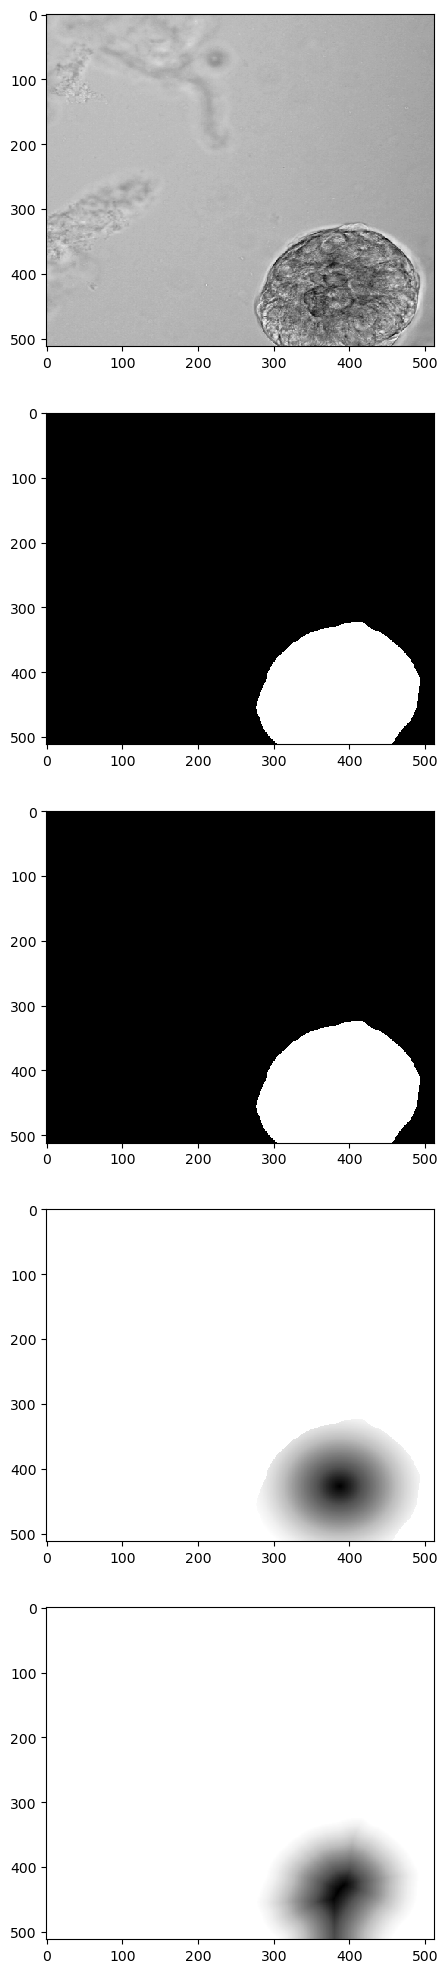

In [15]:
import torch

from torch_em.util.debug import check_loader
from torch_em.data import MinInstanceSampler
from torch_em.util.util import get_random_colors

import micro_sam.training as sam_training
from micro_sam.sample_data import fetch_tracking_example_data, fetch_tracking_segmentation_data
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

batch_size = 1  # pipphe training batch size
patch_shape = (1, 512, 512)  # the size of patches for training
# Load images from multiple files in folder via pattern (here: all tif files)
raw_key, label_key = "*.tif", "*.tif"

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
# NOTE 1: It's important to have densely annotated-labels while training the additional convolutional decoder.
# NOTE 2: In case you do not have labeled images, we recommend using `micro-sam` annotator tools to annotate as many objects as possible per image for best performance.
train_instance_segmentation = True

# NOTE: The dataloader internally takes care of adding label transforms: i.e. used to convert the ground-truth
# labels to the desired instances for finetuning Segment Anythhing, or, to learn the foreground and distances
# to the object centers and object boundaries for automatic segmentation.

# There are cases where our inputs are large and the labeled objects are not evenly distributed across the image.
# For this we use samplers, which ensure that valid inputs are chosen subjected to the paired labels.
# The sampler chosen below makes sure that the chosen inputs have atleast one foreground instance, and filters out small objects.
sampler = MinInstanceSampler(min_size=25)  # NOTE: The choice of 'min_size' value is paired with the same value in 'min_size' filter in 'label_transform'.

train_loader = sam_training.default_sam_loader(
    raw_paths=training_input_dir,
    raw_key=raw_key,
    label_paths=training_label_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    #rois=train_roi,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)

val_loader = sam_training.default_sam_loader(
    raw_paths=val_input_dir,
    raw_key=raw_key,
    label_paths=val_label_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    #rois=val_roi,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)
check_loader(train_loader, 1, plt=True)

### Running the training

In [14]:
n_objects_per_batch = 2  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 20  # how long we train (in epochs)
print('running on: ', device)
# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_b"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "sam"

sam_training.train_sam(
    name=checkpoint_name,
    save_root=os.path.join(output_folder, "models"),
    model_type=model_type,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
)

running on:  cuda


Verifying labels in 'train' dataloader:  24%|██▍       | 12/50 [00:00<00:02, 12.90it/s]


KeyboardInterrupt: 

### zip and upload to OMERO